# Load the data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, MaxPool2D, Flatten, BatchNormalization
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.datasets import cifar10

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

%matplotlib inline

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('X_train_images.shape: ', x_train.shape)
print('X_test_images.shape: ', x_test.shape)
print('y_train_labels.shape: ', y_train.shape)
print('y_test_labels.shape: ', y_test.shape)


X_train_images.shape:  (50000, 32, 32, 3)
X_test_images.shape:  (10000, 32, 32, 3)
y_train_labels.shape:  (50000, 1)
y_test_labels.shape:  (10000, 1)


# Exploring Data

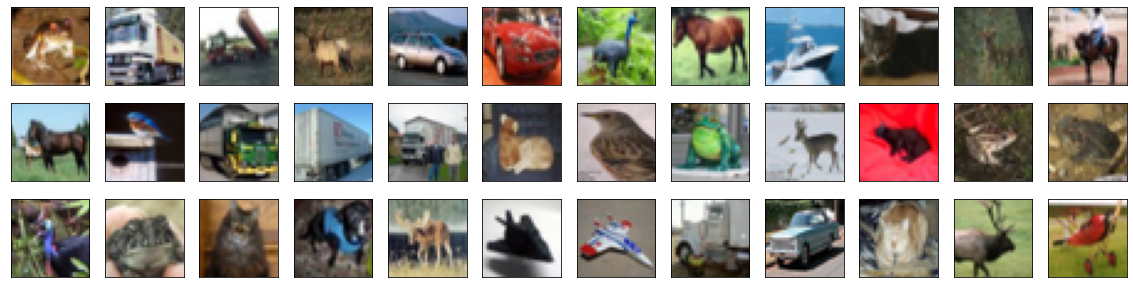

In [9]:
def plot_images(x_train):
    fig = plt.figure(figsize=(20,5))
    for i in range(36):
        ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(x_train[i]))
plot_images(x_train)

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

# Preprocessing Data

In [14]:
def preprocess_data(x_train, y_train, x_test, y_test, val = False):
  num_classes = len(np.unique(y_train))
  y_train_labels = y_train
  y_test_labels = y_test

  #normalize
  X_train = x_train.astype('float32')/255.0
  X_test = x_test.astype('float32')/255.0

  if val == True:
    
    #split training data further into training and validation set
    (X_train, X_valid) = X_train[:20000], X_train[-8500:]
    (y_train_labels, y_valid_labels) = y_train_labels[:20000], y_train_labels[-8500:]

    print('X_train.shape: ', X_train.shape)
    print('X_valid.shape: ', X_valid.shape)
    print('y_train_labels.shape: ', y_train_labels.shape)
    print('y_valid_labels.shape: ', y_valid_labels.shape)
    
    # The target variable is converted to one-hot encoded data 
    y_train = to_categorical(y_train_labels, num_classes)
    y_valid = to_categorical(y_valid_labels, num_classes)
    y_test = to_categorical(y_test_labels, num_classes)
    print('y_train.shape: ', y_train.shape)
    print('y_test.shape: ', y_test.shape)
    return ((X_train, y_train), (X_test, y_test), (X_valid, y_valid))

  else:
    
    print('X_train.shape: ', X_train.shape)
    print('y_train_labels.shape: ', y_train_labels.shape)
    
    # The target variable is converted to one-hot encoded data 
    y_train = to_categorical(y_train_labels, num_classes)
    y_test = to_categorical(y_test_labels, num_classes)
    print('y_train.shape: ', y_train.shape)
    print('y_test.shape: ', y_test.shape)
    
    return ((X_train, y_train), (X_test, y_test))

In [16]:
(x_train, y_train), (x_test, y_test) = preprocess_data(x_train, y_train, x_test, y_test, val = False)

X_train.shape:  (50000, 32, 32, 3)
y_train_labels.shape:  (50000, 1)
y_train.shape:  (50000, 10)
y_test.shape:  (10000, 10)


In [17]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

# Model Training


In [ ]:
# to speed up you should consider using a GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # <- if it shows gpu here we're good to go!

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12390229927613928202
xla_global_id: -1
]


In [18]:
def plot_loss_accuracy(history, plot_loss_only= False):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    ax1.plot(history.history['loss'])
    # ax1.plot(history.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    # ax1.legend(['Train', 'Val'], loc='lower right')    
    ax1.legend(['Train'], loc='lower right') 
        
    if not plot_loss_only:
        ax2.plot(history.history['accuracy'])
        # ax2.plot(history.history['val_accuracy'])
        ax2.set_title('Model accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.legend(['Train', 'Val'], loc='lower right') 
        ax2.legend(['Train'], loc='lower right')   
    plt.show()

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
def report(predictions, y_test):
    dict = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}
    cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
    
    print("Classification Report:\n")
    cr=classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis=1), 
                                target_names=list(dict.values()))
    print(cr)
    
    #plot confusion_matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, xticklabels = list(dict.values()), yticklabels = list(dict.values()), fmt="d")

## CNN


In [20]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [21]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [22]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint   
import time
cnn_start = time.time() # for stopwatch
# train the model

hist = model.fit(x_train, y_train, batch_size=32, epochs=100,verbose=2, shuffle=True)
cnn_end = time.time()
cnn_took = cnn_end -cnn_start
print("took %s seconds"%(cnn_took))


Epoch 1/100
1563/1563 - 66s - loss: 1.5004 - accuracy: 0.4515 - 66s/epoch - 42ms/step
Epoch 2/100
1563/1563 - 66s - loss: 1.1543 - accuracy: 0.5877 - 66s/epoch - 42ms/step
Epoch 3/100
1563/1563 - 66s - loss: 1.0174 - accuracy: 0.6412 - 66s/epoch - 43ms/step
Epoch 4/100
1563/1563 - 66s - loss: 0.9239 - accuracy: 0.6735 - 66s/epoch - 42ms/step
Epoch 5/100
1563/1563 - 65s - loss: 0.8546 - accuracy: 0.6986 - 65s/epoch - 41ms/step
Epoch 6/100
1563/1563 - 64s - loss: 0.7972 - accuracy: 0.7151 - 64s/epoch - 41ms/step
Epoch 7/100
1563/1563 - 65s - loss: 0.7378 - accuracy: 0.7356 - 65s/epoch - 41ms/step
Epoch 8/100
1563/1563 - 64s - loss: 0.7013 - accuracy: 0.7512 - 64s/epoch - 41ms/step
Epoch 9/100
1563/1563 - 64s - loss: 0.6606 - accuracy: 0.7652 - 64s/epoch - 41ms/step
Epoch 10/100
1563/1563 - 63s - loss: 0.6285 - accuracy: 0.7740 - 63s/epoch - 41ms/step
Epoch 11/100
1563/1563 - 63s - loss: 0.6031 - accuracy: 0.7865 - 63s/epoch - 41ms/step
Epoch 12/100
1563/1563 - 63s - loss: 0.5771 - accura

### CNN evaluation


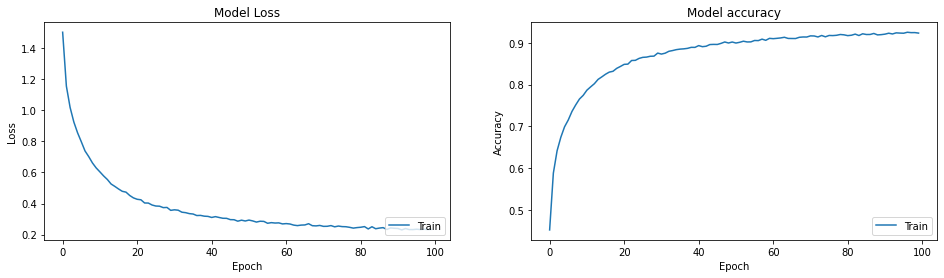

In [ ]:
plot_loss_accuracy(hist)

In [ ]:
#model.load_weights('CNN.best_weights.hdf5')
# evaluate and print test accuracy
cnn_score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', cnn_score[1])


 Test accuracy: 0.7480999827384949


Time to Test CNN: 4.029947881000226
Classification Report:

              precision    recall  f1-score   support

    Airplane       0.79      0.79      0.79      1000
  Automobile       0.88      0.85      0.87      1000
        Bird       0.68      0.61      0.64      1000
         Cat       0.55      0.57      0.56      1000
        Deer       0.69      0.67      0.68      1000
         Dog       0.63      0.66      0.64      1000
        Frog       0.80      0.82      0.81      1000
       Horse       0.83      0.77      0.80      1000
        Ship       0.85      0.87      0.86      1000
       Truck       0.79      0.85      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



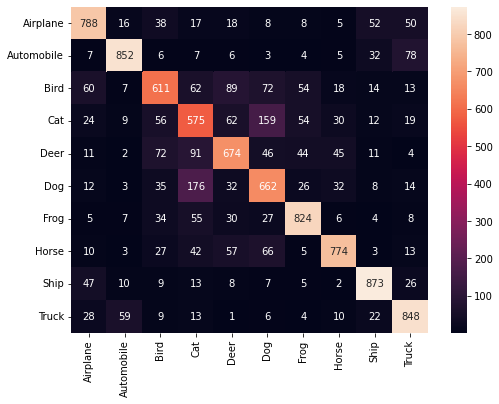

In [ ]:
import timeit
start = timeit.default_timer()
predictions = model.predict(x_test)
stop = timeit.default_timer()
print('Time to Test CNN:', stop-start)
report(predictions, y_test)

# Visualization of some results
Now let us have a look at some predictions that were done by the CNN

Green labels are right predictions, red are wrong predictions. 
 The one in the paranthesis is the ground truth(real), the first label is the prediction by the CNN


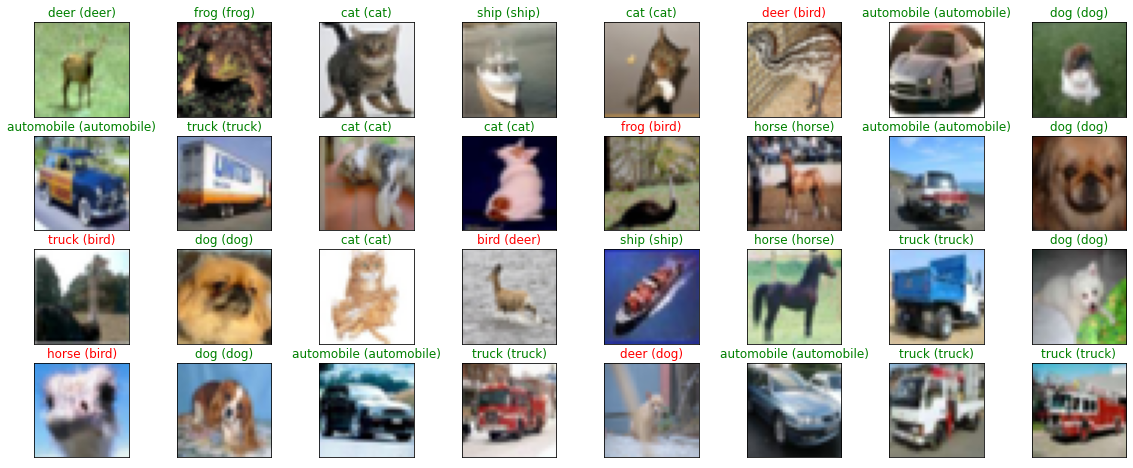

In [ ]:
# get predictions on the test set
y_hat = model.predict(x_test)

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# plot a random sample of test images, their predicted labels, and ground truth

print("Green labels are right predictions, red are wrong predictions. \n The one in the paranthesis is the ground truth(real), the first label is the prediction by the CNN")
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))